In [1]:
import numpy as np
from sklearn.decomposition import KernelPCA

In [2]:
from soap import *

In [3]:
_, structure, species = read_cif("CIF_files/DB0-m1_o14_smb_repeat.cif")

In [4]:
soap_out, soap = S(structure = structure, species = species)

In [5]:
soap_out.shape

(213, 20)

In [6]:
N_env, N_feat = soap_out.shape

In [46]:
# 1) Build the N_env × N_env kernel among environments.  
#    For example, use an RBF kernel with some gamma > 0.
def rbf_kernel(u, v, gamma=1e-3):
    diff = u - v
    return np.exp(-gamma * (diff @ diff))

K = np.zeros((N_feat, N_feat))
for i in range(N_feat):
    for j in range(N_feat):
        K[i, j] = rbf_kernel(soap_out[:,i], soap_out[:,j], gamma=1e-3)

eigvals, eigvecs = np.linalg.eigh(K)
alpha = eigvecs[:, -1]       # shape = (N_env,)
# (Optionally, you can normalize alpha so that sum(alpha^2)=1 or so that sum(alpha)=1, etc.)
alpha = alpha / np.linalg.norm(alpha)

# # --- 3) Form the weighted‐sum row d = alpha^T @ soap_out ---
# d = alpha.reshape(1, N_feat) @ soap_out   # shape = (1, N_feat)

# print("collapsed descriptor shape:", d.shape)

In [47]:
alpha.shape

(20,)

In [48]:
N_feat

20

In [49]:
alpha.shape

(20,)

In [52]:
soap_out.shape

(213, 20)

In [50]:
d = (soap_out * alpha).mean(axis=0, keepdims=True)

In [51]:
d.shape

(1, 20)

In [31]:
d[0]

array([ 1.98887248e-02,  1.42402717e-02,  2.00565801e-03, -1.38706216e-02,
        4.36124519e-02, -7.17911631e-04,  2.67829005e-03, -3.90048751e-04,
        2.08858708e-32,  8.33363883e-02,  8.30706535e-02, -4.17494182e-03,
        3.24709208e-02, -3.61391006e-03,  4.16059825e-02,  6.06245800e-03,
        1.00896216e-01,  7.87191977e-04,  7.62855528e-02,  2.17593092e-03])

In [35]:
si,_ = S(structure = structure, species = species, average = "inner")

In [36]:
si

array([ 1.52091564e+00,  4.50189564e-05,  4.16378818e+00, -2.95287154e-05,
        1.03914068e+00,  2.32330997e-06,  2.98309005e-01, -1.78135509e-05,
        1.13991411e+01,  4.20726344e-05,  2.84484003e+00, -2.26701741e-05,
        8.16676138e-01,  1.01262552e-05,  7.09975838e-01,  2.98115188e-05,
        2.03814738e-01, -9.46465465e-06,  5.85096637e-02,  1.71519504e-05])

In [38]:
so,_ = S(structure = structure, species = species, average = "outer")

In [39]:
so

array([ 2.77902631e+00,  5.32198372e-02,  4.11588378e+00, -5.19847926e-02,
        1.63876232e-01, -2.68026443e-03,  9.99165625e-03, -1.45617068e-03,
        1.54767122e+01,  3.17557746e-01,  1.59166562e+00, -1.56041520e-02,
        1.21731496e-01, -1.35054514e-02,  1.99147215e+00,  2.26188261e-02,
        4.92624250e-01,  2.93805103e-03,  4.62426975e-01,  8.11873260e-03])

In [40]:
import numpy as np
import matplotlib.pyplot as plt

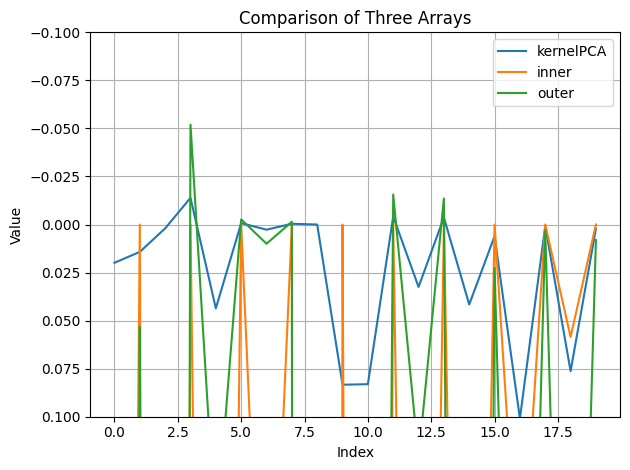

In [43]:
plt.plot(np.arange(20), d[0], label='kernelPCA')
plt.plot(np.arange(20), si, label='inner')
plt.plot(np.arange(20), so, label='outer')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of Three Arrays')
plt.legend()
plt.ylim(0.1,-0.1)
plt.grid()
plt.tight_layout()
plt.show()

# ML

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.neural_network import MLPRegressor


In [32]:
# Read feature descriptors
X = pd.read_csv('TrkernelPCA_soap_mofs.csv')

# Read labels
y = pd.read_csv('id_labels.csv')


In [33]:
print(X.shape)
print(y.shape)

(3089, 559)
(3089, 2)


In [4]:
X['filename'] = X['filename'].str.replace('.cif', ' ', regex=False)

In [5]:
X.head()

,V-V_1,V-V_2,V-O_1,V-O_2,V-C_1,V-C_2,V-H_1,V-H_2,O-O_1,O-O_2,...,Mn-Cr_1,Mn-Cr_2,Al-F_1,Al-F_2,Br-Co_1,Br-Co_2,O-Ni_1,O-Ni_2,Ti-F_1,Ti-F_2
0,0.304977,0.009443,0.354593,-0.002281,0.013655,0.000009,0.000436,-0.000104,0.004724,0.044924,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000016,0.044700,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.271580,0.007100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.055176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040675,0.001881,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
y.head()

,id,label
0,DB5-hypotheticalMOF_17652_0_0_1_21_9_7_repeat,13.791591
1,DB0-m2_o8_o23_f0_pcu.sym.80_repeat,3.786996
2,DB0-m29_o90_o1500_f0_pts.sym.31_repeat,9.382537
3,DB0-m3_o48_o25_f0_fsc.sym.3_repeat,11.650365
4,DB0-m2_o1_o9_f0_nbo.sym.104_repeat,1.412915


In [7]:
X.set_index('filename', inplace = True)

In [8]:
y.set_index('id', inplace = True)

In [9]:
X.sort_index(inplace=True)

In [10]:
y.sort_index(inplace=True)

In [11]:
print("Are they exactly equal?", (X.index == y.index).all())

Are they exactly equal? True


In [12]:
X

,V-V_1,V-V_2,V-O_1,V-O_2,V-C_1,V-C_2,V-H_1,V-H_2,O-O_1,O-O_2,...,Mn-Cr_1,Mn-Cr_2,Al-F_1,Al-F_2,Br-Co_1,Br-Co_2,O-Ni_1,O-Ni_2,Ti-F_1,Ti-F_2
filename,,,,,,,,,,,,,,,,,,,,,
DB0-m12_o14_bcu_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
DB0-m12_o8_o32_tfz-d_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
DB0-m15_o11_o140_f0_fsc_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.533391e-06,0.045546,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
DB0-m15_o14_o137_f0_fsc_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.719869e-08,0.055066,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
DB0-m15_o15_o48_f0_fsc_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.351749e-08,0.059341,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DB7-ddmof_5561_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.751989e-48,0.074777,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
DB7-ddmof_5786_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.105661e-36,0.053265,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
DB7-ddmof_5952_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.582691e-39,0.032377,...,0.0,0.0,0.0,0.0,0.000125,0.000001,0.0,0.0,0.0,0.0


In [30]:
for i in range(len(X.columns)):
    print(i, X.columns[i])

0 V-V_1
1 V-V_2
2 V-O_1
3 V-O_2
4 V-C_1
5 V-C_2
6 V-H_1
7 V-H_2
8 O-O_1
9 O-O_2
10 O-C_1
11 O-C_2
12 O-H_1
13 O-H_2
14 C-C_1
15 C-C_2
16 C-H_1
17 C-H_2
18 H-H_1
19 H-H_2
20 Zn-Zn_1
21 Zn-Zn_2
22 Zn-O_1
23 Zn-O_2
24 Zn-N_1
25 Zn-N_2
26 Zn-H_1
27 Zn-H_2
28 Zn-C_1
29 Zn-C_2
30 O-N_1
31 O-N_2
32 N-N_1
33 N-N_2
34 N-H_1
35 N-H_2
36 N-C_1
37 N-C_2
38 H-C_1
39 H-C_2
40 O-Zn_1
41 O-Zn_2
42 Er-Er_1
43 Er-Er_2
44 Er-O_1
45 Er-O_2
46 Er-C_1
47 Er-C_2
48 Er-H_1
49 Er-H_2
50 Zn-F_1
51 Zn-F_2
52 N-O_1
53 N-O_2
54 N-F_1
55 N-F_2
56 O-F_1
57 O-F_2
58 H-F_1
59 H-F_2
60 C-F_1
61 C-F_2
62 F-F_1
63 F-F_2
64 N-Fe_1
65 N-Fe_2
66 O-Fe_1
67 O-Fe_2
68 H-Fe_1
69 H-Fe_2
70 C-Fe_1
71 C-Fe_2
72 Fe-Fe_1
73 Fe-Fe_2
74 O-Cu_1
75 O-Cu_2
76 O-Li_1
77 O-Li_2
78 Cu-Cu_1
79 Cu-Cu_2
80 Cu-H_1
81 Cu-H_2
82 Cu-C_1
83 Cu-C_2
84 Cu-Li_1
85 Cu-Li_2
86 H-Li_1
87 H-Li_2
88 C-Li_1
89 C-Li_2
90 Li-Li_1
91 Li-Li_2
92 Zn-S_1
93 Zn-S_2
94 Zn-Li_1
95 Zn-Li_2
96 O-S_1
97 O-S_2
98 S-S_1
99 S-S_2
100 S-H_1
101 S-H_2
102 S-C_1
103 S-C_2
10

In [13]:
y

,label
id,
DB0-m12_o14_bcu_repeat,16.427428
DB0-m12_o8_o32_tfz-d_repeat,7.214721
DB0-m15_o11_o140_f0_fsc_repeat,16.199601
DB0-m15_o14_o137_f0_fsc_repeat,8.401891
DB0-m15_o15_o48_f0_fsc_repeat,5.446165
...,...
DB7-ddmof_5561_repeat,4.954847
DB7-ddmof_5786_repeat,5.020765
DB7-ddmof_5952_repeat,6.185781


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [15]:
X

,V-V_1,V-V_2,V-O_1,V-O_2,V-C_1,V-C_2,V-H_1,V-H_2,O-O_1,O-O_2,...,Mn-Cr_1,Mn-Cr_2,Al-F_1,Al-F_2,Br-Co_1,Br-Co_2,O-Ni_1,O-Ni_2,Ti-F_1,Ti-F_2
filename,,,,,,,,,,,,,,,,,,,,,
DB0-m12_o14_bcu_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
DB0-m12_o8_o32_tfz-d_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
DB0-m15_o11_o140_f0_fsc_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.533391e-06,0.045546,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
DB0-m15_o14_o137_f0_fsc_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.719869e-08,0.055066,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
DB0-m15_o15_o48_f0_fsc_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.351749e-08,0.059341,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DB7-ddmof_5561_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.751989e-48,0.074777,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
DB7-ddmof_5786_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.105661e-36,0.053265,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
DB7-ddmof_5952_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.582691e-39,0.032377,...,0.0,0.0,0.0,0.0,0.000125,0.000001,0.0,0.0,0.0,0.0


In [16]:
# Step 1: Scale X
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Step 3: Train linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Step 4: Predict
y_pred = model.predict(X_test)

# Step 5: Evaluate
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

RMSE: 220176971812418.94
R² Score: -8.237137209950335e+26


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize Random Forest
rf = RandomForestRegressor(n_estimators=300, random_state=42)

# Train
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)



/home/mmm9886/.conda/envs/pyemma/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [19]:
# Evaluate
print("Random Forest RMSE:", root_mean_squared_error(y_test, y_pred_rf))
print("Random Forest R²:", r2_score(y_test, y_pred_rf))

Random Forest RMSE: 3.869441849022929
Random Forest R²: 0.7455929393803633


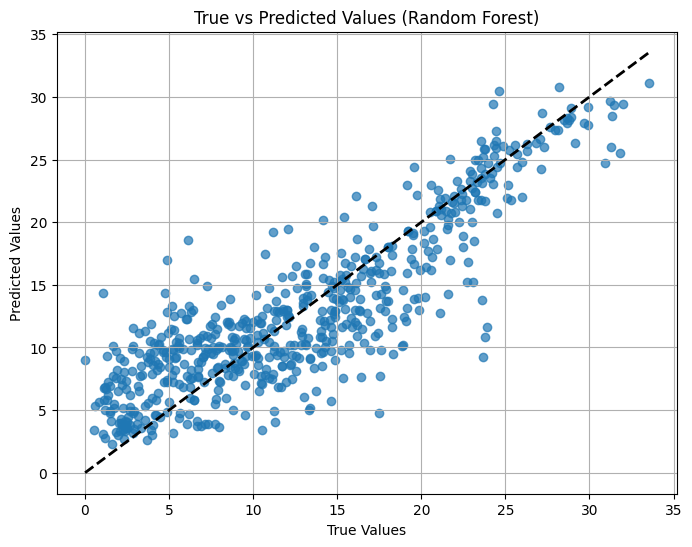

In [20]:
# Make a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.7)

# Plot a diagonal reference line (perfect prediction)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# Labels
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values (Random Forest)')
plt.grid(True)
plt.show()

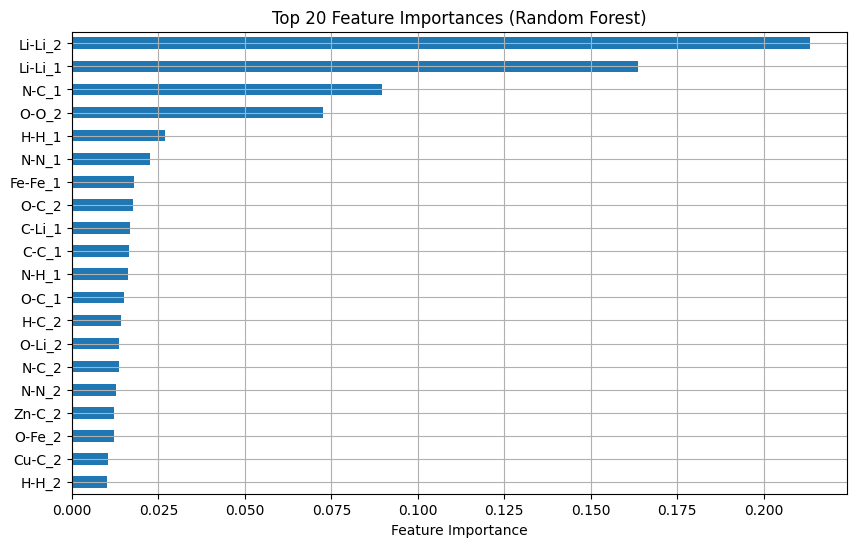

In [21]:
# 1. Get feature importances
importances = rf.feature_importances_

# 2. Map them to feature names
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names)

# 3. Sort them descending
feature_importances = feature_importances.sort_values(ascending=False)

# 4. Plot the top N features
top_n = 20  # you can change to top 10, 20, etc.

plt.figure(figsize=(10, 6))
feature_importances[:top_n].plot(kind='barh')
plt.gca().invert_yaxis()  # Highest importance at top
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Feature Importances (Random Forest)')
plt.grid(True)
plt.show()

In [22]:
from pycaret.regression import *

In [23]:
y

,label
id,
DB0-m12_o14_bcu_repeat,16.427428
DB0-m12_o8_o32_tfz-d_repeat,7.214721
DB0-m15_o11_o140_f0_fsc_repeat,16.199601
DB0-m15_o14_o137_f0_fsc_repeat,8.401891
DB0-m15_o15_o48_f0_fsc_repeat,5.446165
...,...
DB7-ddmof_5561_repeat,4.954847
DB7-ddmof_5786_repeat,5.020765
DB7-ddmof_5952_repeat,6.185781


In [24]:
data = pd.concat([X, y], axis = 1)

In [25]:
data

,V-V_1,V-V_2,V-O_1,V-O_2,V-C_1,V-C_2,V-H_1,V-H_2,O-O_1,O-O_2,...,Mn-Cr_2,Al-F_1,Al-F_2,Br-Co_1,Br-Co_2,O-Ni_1,O-Ni_2,Ti-F_1,Ti-F_2,label
DB0-m12_o14_bcu_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,16.427428
DB0-m12_o8_o32_tfz-d_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,7.214721
DB0-m15_o11_o140_f0_fsc_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.533391e-06,0.045546,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,16.199601
DB0-m15_o14_o137_f0_fsc_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.719869e-08,0.055066,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,8.401891
DB0-m15_o15_o48_f0_fsc_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.351749e-08,0.059341,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,5.446165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DB7-ddmof_5561_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.751989e-48,0.074777,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,4.954847
DB7-ddmof_5786_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.105661e-36,0.053265,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,5.020765
DB7-ddmof_5952_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.582691e-39,0.032377,...,0.0,0.0,0.0,0.000125,0.000001,0.0,0.0,0.0,0.0,6.185781
DB7-ddmof_6321_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.897499e-10,0.019461,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,3.526927


In [28]:
data.columns

Index(['V-V_1', 'V-V_2', 'V-O_1', 'V-O_2', 'V-C_1', 'V-C_2', 'V-H_1', 'V-H_2',
       'O-O_1', 'O-O_2',
       ...
       'Mn-Cr_2', 'Al-F_1', 'Al-F_2', 'Br-Co_1', 'Br-Co_2', 'O-Ni_1', 'O-Ni_2',
       'Ti-F_1', 'Ti-F_2', 'label'],
      dtype='object', length=567)

## exp1 = setup(data, target='label', session_id=123)

In [27]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,2.9893,15.3718,3.9180,0.7472,0.4221,1.3224,0.6650
lightgbm,Light Gradient Boosting Machine,3.0688,16.1266,4.0123,0.7355,0.4286,1.2012,50.2360
rf,Random Forest Regressor,3.1105,16.3199,4.0359,0.7323,0.4378,1.2689,0.9540
xgboost,Extreme Gradient Boosting,3.1827,17.4902,4.1756,0.7127,0.4488,1.3988,0.2530
gbr,Gradient Boosting Regressor,3.4890,18.4487,4.2913,0.6975,0.4652,1.4999,0.4260
ada,AdaBoost Regressor,4.2305,24.9794,4.9970,0.5903,0.5413,1.7173,0.2130
knn,K Neighbors Regressor,3.7730,25.2944,5.0246,0.5836,0.4965,1.8018,0.0550
br,Bayesian Ridge,4.3883,29.0619,5.3875,0.5233,0.5382,2.0019,0.0860
omp,Orthogonal Matching Pursuit,4.4704,30.6011,5.5296,0.4977,0.5446,1.8332,0.0600
huber,Huber Regressor,4.4961,31.1462,5.5769,0.4874,0.5473,2.1051,0.2070
